# Lab 6 

Sicheng Mao

## Part1

### model.py

In [1]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

In [57]:
class GATLayer(nn.Module):
    """GAT layer"""
    def __init__(self, n_feat, n_hidden, alpha=0.05):
        super(GATLayer, self).__init__()
        self.fc = nn.Linear(n_feat, n_hidden, bias=False)
        self.a = nn.Linear(2*n_hidden, 1)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, adj):
        
        ############## Task 1
    
        ##################
        z = self.fc(x)
        indices = adj.coalesce().indices() # coalesce is a torch method for merging uncoalesced sparse COO tensors into tensors with unique index
        # indices is a 2 * m tensor, where indices[0] = the first component of all pairs of edge, indices[1] = the second component of all pairs of edge.
        concat = torch.cat((z[indices[0]],z[indices[1]]), dim=1)
        h = self.leakyrelu(self.a(concat))
        ##################

        h = torch.exp(h.squeeze())
        unique = torch.unique(indices[0,:]) # like numpy.unique
        t = torch.zeros(unique.size(0), device=x.device)
        h_sum = t.scatter_add(0, indices[0,:], h) # sum up h along axis 0 by index in indices[0,:]
        h_norm = torch.gather(h_sum, 0, indices[0,:])
        alpha = torch.div(h, h_norm)
        adj_att = torch.sparse.FloatTensor(indices, alpha, torch.Size([x.size(0), x.size(0)])).to(x.device)
        
        ##################
        out = torch.sparse.mm(adj_att, z)
        ##################

        return out, alpha


class GNN(nn.Module):
    """GNN model"""
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GNN, self).__init__()
        self.mp1 = GATLayer(nfeat, nhid)
        self.mp2 = GATLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        
        ############## Tasks 2 and 4
    
        ##################
        x,_ = self.mp1(x, adj)
        x = self.relu(x)
        x = self.dropout(x)
        x,T = self.mp2(x, adj)
        x = self.fc(x)
        ##################

        return F.log_softmax(x, dim=1), T

### utils.py

In [49]:
import numpy as np
import torch

def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [50]:
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# from models import GNN
# from utils import sparse_to_torch_sparse


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
n_hidden = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
# G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
# class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

Number of nodes: 34
Number of edges: 78


In [55]:
############## Task 3
feature_dim = 4 # how to choose?
adj = nx.adjacency_matrix(G)# your code here #
features = np.random.randn(n, feature_dim)# your code here #
# features = np.ones((n, feature_dim))# for question 2

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

In [58]:
# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, _ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")

# Testing
model.eval()
output, T = model(features, adj)
loss_test = F.nll_loss(output[idx_test], y[idx_test])
acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test))

Epoch: 001 loss_train: 0.6884 acc_train: 0.5556 time: 0.0070s
Epoch: 002 loss_train: 0.6806 acc_train: 0.5556 time: 0.0037s
Epoch: 003 loss_train: 0.6713 acc_train: 0.5556 time: 0.0030s
Epoch: 004 loss_train: 0.6587 acc_train: 0.5556 time: 0.0031s
Epoch: 005 loss_train: 0.6469 acc_train: 0.5556 time: 0.0047s
Epoch: 006 loss_train: 0.6316 acc_train: 0.5556 time: 0.0042s
Epoch: 007 loss_train: 0.6159 acc_train: 0.5556 time: 0.0042s
Epoch: 008 loss_train: 0.6126 acc_train: 0.5556 time: 0.0041s
Epoch: 009 loss_train: 0.5639 acc_train: 0.7407 time: 0.0136s
Epoch: 010 loss_train: 0.5315 acc_train: 0.8889 time: 0.0175s
Epoch: 011 loss_train: 0.5019 acc_train: 0.8889 time: 0.0085s
Epoch: 012 loss_train: 0.4748 acc_train: 0.8889 time: 0.0043s
Epoch: 013 loss_train: 0.4173 acc_train: 0.8889 time: 0.0109s
Epoch: 014 loss_train: 0.4056 acc_train: 0.8889 time: 0.0047s
Epoch: 015 loss_train: 0.3812 acc_train: 0.8889 time: 0.0051s
Epoch: 016 loss_train: 0.3525 acc_train: 0.8889 time: 0.0052s
Epoch: 0

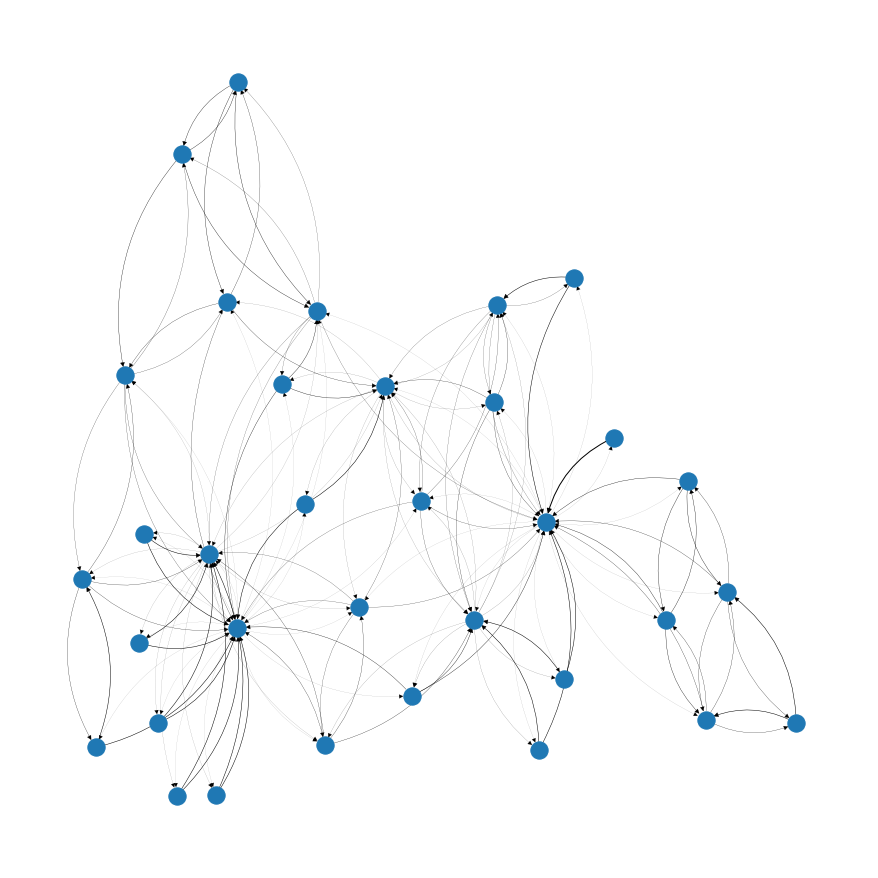

In [59]:
############## Task 4
alpha = T.detach().cpu().numpy()# your code here #

# Dictionary that maps indices of nodes to nodes
idx_to_node = dict()
for i,node in enumerate(G.nodes()):
    idx_to_node[i] = node

# Creates a directed karate network
G_directed = G.to_directed()

# Retrieves nonzero indices of the adjacency matrix
indices = adj.coalesce().indices().detach().cpu().numpy()

# Annotates edges with the learned attention weights 
for i in range(indices.shape[1]):
    G_directed[idx_to_node[indices[0,i]]][idx_to_node[indices[1,i]]]['weight'] = alpha[i]

weights = [G_directed[u][v]['weight'] for u,v in G_directed.edges()]

# Visualizes attention weights
plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(G_directed)
arc_rad = 0.25
nx.draw(G_directed, width=weights, connectionstyle=f'arc3, rad = {arc_rad}')
plt.show()

## Part2

### utils.py

In [61]:
import networkx as nx
import numpy as np
import torch
from random import randint

def create_dataset():
    Gs = list()
    y = list()

    ############## Task 5
    ##################
    for i in range(50):
        G1 = nx.fast_gnp_random_graph(np.random.randint(10,20), 0.2)
        Gs.append(G1)
        y.append(0)
        G2 = nx.fast_gnp_random_graph(np.random.randint(10,20), 0.4)
        Gs.append(G2)
        y.append(1)
    ##################

    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### model.py

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 6
    
        ##################
        adj_normalized = adj + sparse_mx_to_torch_sparse_tensor(sp.identity(adj.shape[0]))
        # message passing layers
        x = self.relu(adj_normalized @ self.fc1(x_in))
        x = self.relu(adj_normalized @ self.fc2(x))
        ##################
        
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(self.device)
        out = out.scatter_add_(0, idx, x)
        
        ##################
        out = self.fc4(self.relu(self.fc3(out)))
        ##################

        return F.log_softmax(out, dim=1)

### gnn.py

In [87]:
import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

# from models import GNN
# from utils import create_dataset, sparse_mx_to_torch_sparse_tensor

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [93]:
# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        ############## Task 7
        
        ##################
        Gs_batch = G_train[i:i+batch_size]
        adj_batch = sparse_mx_to_torch_sparse_tensor(sp.block_diag([nx.adjacency_matrix(G).todense() for G in Gs_batch])).to(device)
        for j, G in enumerate(Gs_batch):
            idx_batch.extend(G.number_of_nodes()*[j])
        y_batch = torch.LongTensor(y_train[i:i+batch_size]).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        features_batch = torch.ones((len(idx_batch), 1)).to(device)
        ##################
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')

Epoch: 0001 loss_train: 0.2505 acc_train: 0.8889 time: 0.0846s
Epoch: 0011 loss_train: 0.2474 acc_train: 0.9000 time: 0.0680s
Epoch: 0021 loss_train: 0.2495 acc_train: 0.8889 time: 0.0651s
Epoch: 0031 loss_train: 0.2429 acc_train: 0.9000 time: 0.0648s
Epoch: 0041 loss_train: 0.2287 acc_train: 0.9222 time: 0.0667s
Epoch: 0051 loss_train: 0.2292 acc_train: 0.9333 time: 0.0644s
Epoch: 0061 loss_train: 0.2164 acc_train: 0.9333 time: 0.0705s
Epoch: 0071 loss_train: 0.2164 acc_train: 0.9222 time: 0.0636s
Epoch: 0081 loss_train: 0.2153 acc_train: 0.9333 time: 0.0667s
Epoch: 0091 loss_train: 0.2136 acc_train: 0.9222 time: 0.0681s
Epoch: 0101 loss_train: 0.1980 acc_train: 0.9333 time: 0.0657s
Epoch: 0111 loss_train: 0.1986 acc_train: 0.9444 time: 0.0673s
Epoch: 0121 loss_train: 0.2008 acc_train: 0.9222 time: 0.0756s
Epoch: 0131 loss_train: 0.1893 acc_train: 0.9333 time: 0.0671s
Epoch: 0141 loss_train: 0.1874 acc_train: 0.9333 time: 0.0674s
Epoch: 0151 loss_train: 0.1898 acc_train: 0.9333 time: 

In [94]:
# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 7
    
    ##################
    Gs_batch = G_test[i:i+batch_size]
    adj_batch = sparse_mx_to_torch_sparse_tensor(sp.block_diag([nx.adjacency_matrix(G).todense() for G in Gs_batch])).to(device)
    # adj_batch += sp.np.eye(adj_batch.shape[0]))
    for j, G in enumerate(Gs_batch):
        idx_batch.extend(G.number_of_nodes()*[j])
    y_batch = torch.LongTensor(y_test[i:i+batch_size]).to(device)
    idx_batch = torch.LongTensor(idx_batch).to(device)
    features_batch = torch.ones((len(idx_batch), 1)).to(device)
    ##################

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))

loss_test: 0.3857 acc_test: 0.8000 time: 14.4085s


### question 3

In [95]:
Z1 = np.array([[2.2,-0.6,1.4],[0.2,1.8,1.5],[0.5,1.1,-1.0]])
Z1

array([[ 2.2, -0.6,  1.4],
       [ 0.2,  1.8,  1.5],
       [ 0.5,  1.1, -1. ]])

In [96]:
Z2 = np.array([[0.7,0.1,1.3],[1.2,-0.9,0.3],[2.2,0.9,1.2],[-0.7,1.8,1.5]])
Z2

array([[ 0.7,  0.1,  1.3],
       [ 1.2, -0.9,  0.3],
       [ 2.2,  0.9,  1.2],
       [-0.7,  1.8,  1.5]])

In [97]:
Z3 = np.array([[-0.4,1.8,0.1],[2.2,-0.6,1.5]])
Z3

array([[-0.4,  1.8,  0.1],
       [ 2.2, -0.6,  1.5]])

In [120]:
Z1.sum(axis=0), Z2.sum(axis=0), Z3.sum(axis=0)

(array([2.9, 2.3, 1.9]), array([3.4, 1.9, 4.3]), array([1.8, 1.2, 1.6]))

In [121]:
Z1.mean(axis=0), Z2.mean(axis=0), Z3.mean(axis=0)

(array([0.96666667, 0.76666667, 0.63333333]),
 array([0.85 , 0.475, 1.075]),
 array([0.9, 0.6, 0.8]))

In [122]:
Z1.max(axis=0), Z2.max(axis=0), Z3.max(axis=0)

(array([2.2, 1.8, 1.5]), array([2.2, 1.8, 1.5]), array([2.2, 1.8, 1.5]))